In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
import matplotlib.pyplot as plt

In [2]:
ticker = "^GSPC"
data = yf.download(ticker, start="1960-01-01", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_11836\2793084089.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1960-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1960-01-04  59.910000  59.910000  59.910000  59.910000  3990000
1960-01-05  60.389999  60.389999  60.389999  60.389999  3710000
1960-01-06  60.130001  60.130001  60.130001  60.130001  3730000
1960-01-07  59.689999  59.689999  59.689999  59.689999  3310000
1960-01-08  59.500000  59.500000  59.500000  59.500000  3290000
(15858, 5)


In [4]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data = data.iloc[1:]

In [5]:
model = arch.arch_model(data["DailyReturn"]*1000, vol="GARCH", p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 923796090312.3402
Iteration:      2,   Func. Count:     14,   Neg. LLF: 12188402.664294241
Iteration:      3,   Func. Count:     21,   Neg. LLF: 56316.15451782483
Iteration:      4,   Func. Count:     27,   Neg. LLF: 56192.376620714
Iteration:      5,   Func. Count:     33,   Neg. LLF: 5583550820.0031395
Iteration:      6,   Func. Count:     39,   Neg. LLF: 56370.391117195555
Iteration:      7,   Func. Count:     45,   Neg. LLF: 56169.7555719136
Iteration:      8,   Func. Count:     51,   Neg. LLF: 56178.99098546479
Iteration:      9,   Func. Count:     57,   Neg. LLF: 56157.648427601016
Iteration:     10,   Func. Count:     62,   Neg. LLF: 56157.628385307726
Iteration:     11,   Func. Count:     67,   Neg. LLF: 56157.628269854904
Iteration:     12,   Func. Count:     72,   Neg. LLF: 56157.628261777616
Iteration:     13,   Func. Count:     76,   Neg. LLF: 56157.62826177861
Optimization terminated successfully    (Exit mode 0)
      

In [6]:
data['GARCH_volatility'] = model_fit.conditional_volatility
data['inv_vol'] = 1 / data['GARCH_volatility']
data.head()

Price,Close,High,Low,Open,Volume,DailyReturn,Sign_1d,GARCH_volatility,inv_vol
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,,
Date,,,,,,,,,
1960-01-05,60.389999,60.389999,60.389999,60.389999,3710000,0.007980,1,7.376043,0.135574
1960-01-06,60.130001,60.130001,60.130001,60.130001,3730000,-0.004315,0,7.429550,0.134598
1960-01-07,59.689999,59.689999,59.689999,59.689999,3310000,-0.007344,0,7.262138,0.137701
1960-01-08,59.500000,59.500000,59.500000,59.500000,3290000,-0.003188,0,7.365763,0.135763
1960-01-11,58.770000,58.770000,58.770000,58.770000,3470000,-0.012345,0,7.138952,0.140077


# Deep Learning

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

The window size is actually quite important, because it determines how many lags should be considered. 

In [8]:
NUMBER_OF_LAGS = 20  # number of lagged observations
TRAIN_SIZE = 5000
HIDDEN_DIM = 16
NUM_LAYERS = 1
DROPOUT = 0.0
BATCH_SIZE = 5000
NUMBER_OF_EPOCHS = 50
CLASSIFICATION_THRESHOLD = 0.5

In [9]:
data = data.copy()

# Add lagged returns as features
data['Lag1'] = data['DailyReturn'].shift(1)

data = data.dropna()

# Feature matrix: inv_vol + lagged returns
features = np.column_stack([
    data['GARCH_volatility'].values,
    data['Lag1'].values
])

input_variables = features.shape[1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Currently, the past returns and inverse volatility are used for predicting the next return. This might not be economically sensible as many people believe returns are independent and form a martingale difference sequence (MDS). 

In [10]:
features

array([[ 7.42955007e+00,  7.98008466e-03],
       [ 7.26213762e+00, -4.31461540e-03],
       [ 7.36576344e+00, -7.34442364e-03],
       ...,
       [ 1.20469256e+01, -4.05784403e-03],
       [ 1.20998034e+01, -1.20934704e-02],
       [ 1.26312890e+01,  1.73106343e-02]], shape=(15856, 2))

By using StandardScaler, each variable will be standard normally distributed.

In [11]:
# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features_scaled, NUMBER_OF_LAGS)
y_target = data['Sign_1d'].values[NUMBER_OF_LAGS:]

In [12]:
# Split train/test
X_train = X_lagged[:TRAIN_SIZE]
y_train = y_target[:TRAIN_SIZE]
X_test = X_lagged[TRAIN_SIZE:]
y_test = y_target[TRAIN_SIZE:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

## Define LSTM Model

In [13]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

model = SimpleLSTM(input_dim=input_variables, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [14]:
model

SimpleLSTM(
  (lstm): LSTM(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Model Training

X_train_t contains batch size, sequence length (number of lags) and number of variables.
Pytorch automatically calls forward()-method when input is given to the model.

In [15]:
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(NUMBER_OF_EPOCHS):     # number of seeing the training data for learning parameters
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.7143
Epoch 10: loss = 0.6918
Epoch 20: loss = 0.6915
Epoch 30: loss = 0.6910
Epoch 40: loss = 0.6906


### Out of sample Prediction

In [16]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_pred_sign = (y_pred_test > CLASSIFICATION_THRESHOLD).astype(int)

# --- Results ---
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_sign,
    'Probability': y_pred_test
}, index=data.index[NUMBER_OF_LAGS+TRAIN_SIZE:])

In [17]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report
print("Classification Report:")
print(classification_report(results['Actual'], results['Predicted']))
print("Accuracy:", accuracy_score(results['Actual'], results['Predicted']))

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.39      0.43      5063
           1       0.54      0.63      0.58      5773

    accuracy                           0.51     10836
   macro avg       0.51      0.51      0.50     10836
weighted avg       0.51      0.51      0.51     10836

Accuracy: 0.5148578811369509


Text(0.5, 1.0, 'Predicted Probability of Positive Return')

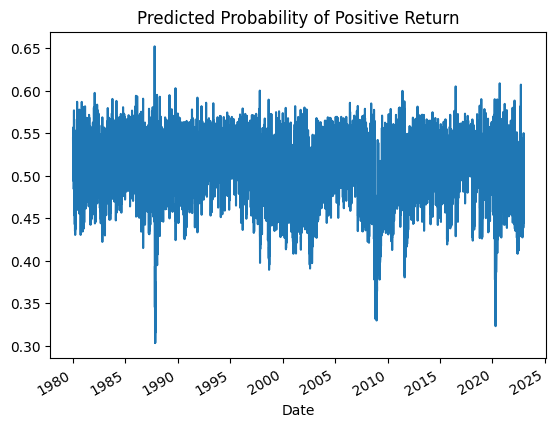

In [18]:
results["Probability"].plot()
plt.title("Predicted Probability of Positive Return")
#plt.ylim(0, 1)